In [1]:
%pylab inline
import rasterio

from smalllib import *

Populating the interactive namespace from numpy and matplotlib


We now want to cross this information with the available DEM to estimate the elevation along the horizons, which are needed to correct the absolute vertical positioning of the horizons, which are measured from the surface. Notice this is not clear from the papers, we will assume so, givig the oppurtinuty to see how to perform this correction.
This step it might not be striclty necessary for a small area like the onw investigated by Chang'e III Yutu rover

Load the data we need:

In [2]:
horizons_f = of("horizons.npz")
hs = np.load(horizons_f, allow_pickle=True)["arr_0"].tolist()
dem_f  = "../rasters/NAC_DTM_CHANGE3.TIF"
dem = rasterio.open(dem_f)

# crop the raster to a meaningful region
We first determine the boundaries for the region we are dealing with

In [3]:
# estimate the bounding box
mi = np.min(hs[0][:,:2],axis=0)
ma = np.max(hs[0][:,:2],axis=0)

In [4]:
# mi = np.array([minx, miny]) # lower left corner
# ma = np.array([maxx, maxy]) # upper right corner

enlarge = 3 # enlarge the region of this size in m to have also the sourrandings

mi -= np.ones(2) * enlarge
ma += np.ones(2) * enlarge

# we also save this data to file for any future use
bb = np.array([*mi, *ma])
np.savetxt(of("region.txt"), bb)

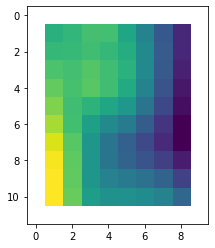

In [5]:
out_img, new_meta = crop_raster_rectangle(dem, mi, ma, of("cropped_dem.tif"))
imshow(out_img[0])

# Upscale the raster
This is also not striclty necessary, but is useful to smooth out elevation values on such low-res raster, it would be better to higher resolution data, but it is not freely available

In [6]:
dem = rasterio.open(of("cropped_dem.tif"))

In [7]:
upscale_factor=5 # split each pixel in 25

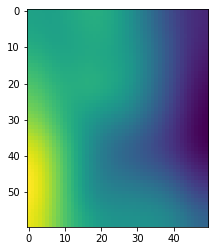

In [8]:
up, newmeta = upsample_raster(dem, of("cropped_dem_up.tif"))
imshow(up[0])

# Sample elevation values

we can now use the upscaled dem for estimating elevations along the path

In [9]:
dem = rasterio.open(of("cropped_dem_up.tif")) # reopen the dem

In [10]:
from smalllib import sampleRasterAtPoints # some methods are in this small module, have a look at that for doc

In [11]:
import geopandas as gpd
from shapely.geometry import Point

tables = [] # we will create a geopandas table for each horizon

for hor in hs: # we are repeating for each horizon, they have different nodes
    tab = gpd.GeoDataFrame()
    
    elevations = sampleRasterAtPoints(dem, hor[:,:2]) # sample elevations
    
    points = [Point(x,y,z+el) for (x,y,z), el in zip(hor, elevations)] # create the points, notice we are adding the computed elevations to z
    tab.geometry = points # and use them as geometry
    tab["surface_elevation"] = elevations
    tab["original_z"] = hor[:,2]
    tables.append(tab)
    


<AxesSubplot:>

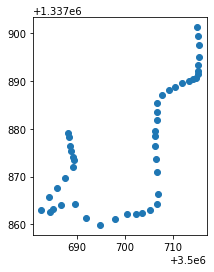

In [12]:
# see the last table we generated, just for reference
tab.plot()

In [13]:
tab[0:5] # see an example

,geometry,surface_elevation,original_z
0,POINT Z (3500715.048 1337901.221 -2633.159),-2627.809082,-5.349957
1,POINT Z (3500715.343 1337899.490 -2633.103),-2627.804199,-5.298919
2,POINT Z (3500715.546 1337897.422 -2633.086),-2627.805908,-5.279779
3,POINT Z (3500715.447 1337894.934 -2633.163),-2627.819580,-5.343577
4,POINT Z (3500715.349 1337893.253 -2633.170),-2627.826660,-5.343577


In [14]:
# save each horizon in the same geopackage, one per layer, so we can also open them in qgis
for i, t in enumerate(tables):
    t.to_file(of("horizons.gpkg"), driver="GPKG", layer=f"{str(i)}")